In [10]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser

from wlenet import config
from wlenet.models.calibrate import step_bias_calib, step_bias_correct
from wlenet.models.utils import load_spec, save_spec, print_spec
from wlenet.dataset.io import load_sim, load_target
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.dataset.figures import show_stamps
from wlenet.models.figures import show_scatter_label_pred, show_first_conv_kernels
from wlenet.models.predict import predict, predict_test_time_aug

In [2]:
model_spec = load_spec('rrg')
model_spec['kwargs_dataset']['sim_names_test'] = ['clash_003_test']
save_calib = True
np.random.seed(1234)

In [3]:
print_spec(model_spec)

{'calib': (6.443278225803035e-05, 0.12013534101250989, 0.00037061950529975797, 0.1298219720200402),
 'kwargs_dataset': {'noise_kernel_factor': 1.0,
                    'noise_kernel_name': 'clash',
                    'post_sim': {'flux_cut_min': -inf, 'flux_factor': 0.32, 'intensity_cutoff': 0.012},
                    'sim_names_test': ['clash_003_test'],
                    'target_header_path': None},
 'trained_name': 'rrg'}


In [4]:
noise_kernel_path = config['calibration_path'] + '/' +  model_spec['kwargs_dataset']['noise_kernel_name'] + '_noise_kernel.npy'
noise_kernel = np.load(expanduser(noise_kernel_path)) *  model_spec['kwargs_dataset']['noise_kernel_factor']
post_sim = model_spec['kwargs_dataset']['post_sim'] if 'post_sim' in model_spec['kwargs_dataset'] else None

source_test = dict(zip(('x', 'y'), load_sim(model_spec['kwargs_dataset']['sim_names_test'], 'test', 2, post_sim=post_sim)))
target_test, _ = load_target(model_spec['kwargs_dataset']['target_header_path'])

seq_test = CorrelatedNoiseSequence(source_test, noise_kernel, target=target_test)

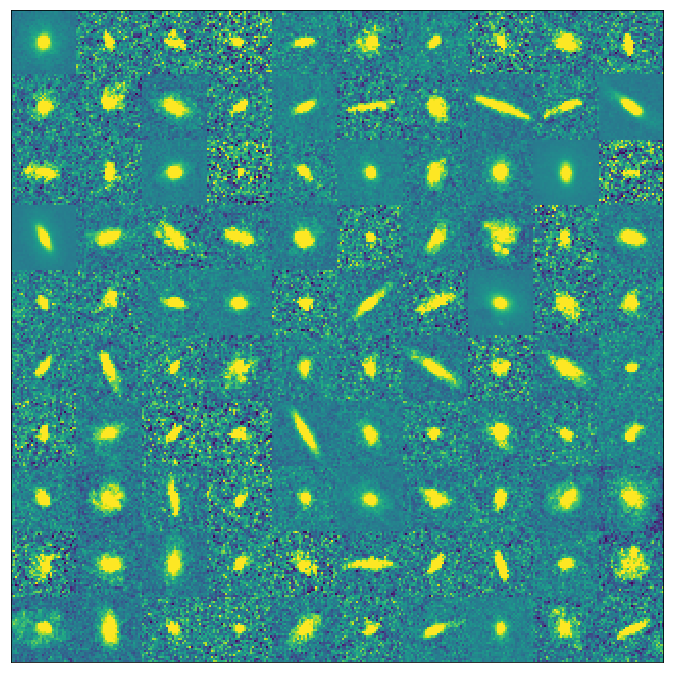

In [5]:
show_stamps(generate_batches(seq_test, 1)[0])

In [6]:
seq_test = CorrelatedNoiseSequence(source_test, noise_kernel, norm_func=None)
x_seq_test, y_seq_test, inds_seq_test = generate_batches(seq_test, 1000)

step biases c1: 0.001, m1: 0.115, c2: 0.001, m2: 0.126
rmse1: 0.258, rmse2: 0.258, (rmse1 + rmse2)/2: 0.258


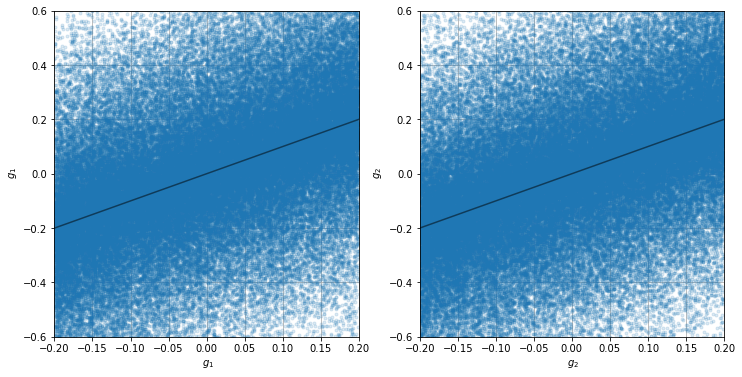

In [7]:
from wlenet.reduction.stamps import half_light_radii, chi_shapes, rrg_shapes
psf_radius = (0.12 / 0.065) / 2.355

radii = half_light_radii(x_seq_test)
y_seq_rrg = rrg_shapes(x_seq_test, radii, psf_radius)

inds = np.all(np.abs(y_seq_rrg) < 1.0, axis=1)
y_seq_rrg = y_seq_rrg[inds, :]
y_seq_test = y_seq_test[inds, :]

y_seq_rrg, calib_rrg, rmse_rrg = step_bias_calib(y_seq_test, y_seq_rrg, verbose=True)
show_scatter_label_pred(y_seq_test, y_seq_rrg, min_g=-0.6, max_g=0.6, min_g_true=-0.2, max_g_true=0.2)

In [8]:
model_spec['calib'] = calib_rrg
if save_calib:
    save_spec(model_spec)

In [13]:
print(np.mean((y_seq_rrg - y_seq_test)**2, axis=0)**0.5)

[0.25819934 0.25805687]


In [14]:
calib_rrg

(0.0005575500959664508,
 0.11512468824660727,
 0.0009657854721445381,
 0.12633541201149057)